# ChEMBL Drug-Like Screening Library Construction
## Final Project: In Silico Identification of Novel α2-selective Positive Allosteric Modulators (PAMs) for GABA-A Receptors in Anxiety Treatment

**Student:** Pablo Rodríguez López.    
**Course**: Computational Structural Biology for Lead Discovery.   
**University**: Polytechnic University of Madrid.    
**Date:** January 2026.   
**Objective:** Build a curated library of drug-like compounds from ChEMBL to serve as the screening set for Filter 1 (Ligand-Based Virtual Screening) targeting α2A-selective compounds.

---

## 1. Library Setup and Configuration

Install required libraries and configure the environment for compound retrieval, validation, and analysis.

In [ ]:
# IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import warnings
warnings.filterwarnings('ignore')

!pip install rdkit -q
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen

# CONFIGURE VISUALIZATION
np.random.seed(42)
plt.rcParams['axes.labelweight'] = 'bold'

print('=' * 70)
print('ChEMBL SCREENING LIBRARY CONSTRUCTION')
print('=' * 70)
print('✓ All libraries imported successfully')
print(f'✓ RDKit version: {Chem.rdBase.rdkitVersion}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 34.5 MB/s eta 0:00:00
ChEMBL SCREENING LIBRARY CONSTRUCTION
✓ All libraries imported successfully
✓ RDKit version: 2025.09.3


## 2. ChEMBL API Access Strategy

### Why the ChEMBL Web Resource Client Failed

The initial approach using `chembl-webresource-client` encountered critical limitations:

1. **API Response Mismatch**: The Python wrapper expects a `results` key in the JSON response, but the ChEMBL REST API actually returns data under the `molecules` key.
2. **Filter Compatibility Issues**: The wrapper's filter syntax (`mw_freebase__gte`, `alogp__lte`, etc.) requires specific pre-computed fields that are not always available or reliable.
3. **Error Handling**: The client's error handling was brittle, failing silently or crashing on edge cases rather than retrying gracefully.

### Successful Solution: Direct REST API with Requests (as seen in class)

According to [ChEMBL API documentation](https://chembl.gitbook.io/chembl-interface-documentation), the REST API supports direct HTTP GET requests:

```
GET https://www.ebi.ac.uk/chembl/api/data/molecule?limit=100&offset=0
```

**Note on filtering:** ChEMBL's REST API does not support complex molecular descriptor filtering. We therefore:
1. Retrieve broad, drug-like compounds in batches
2. Post-process with RDKit to calculate descriptors
3. Apply Lipinski's Rule of Five criteria locally

This approach is more robust and transparent than relying on pre-computed ChEMBL fields.

Drug-like criteria used (Lipinski rule):
- Molecular weight: 150-500
- logP: (-1)-5
- HBA: < 10
- HBD: < 5
- Rotable bonds: < 10


## 3. Define Validation & Descriptor Calculation Functions

Before processing compounds, we define helper functions to:
1. Canonicalize SMILES strings (standardize molecular representation)
2. Calculate molecular descriptors (assess drug-likeness)
3. Validate Lipinski's Rule of Five criteria

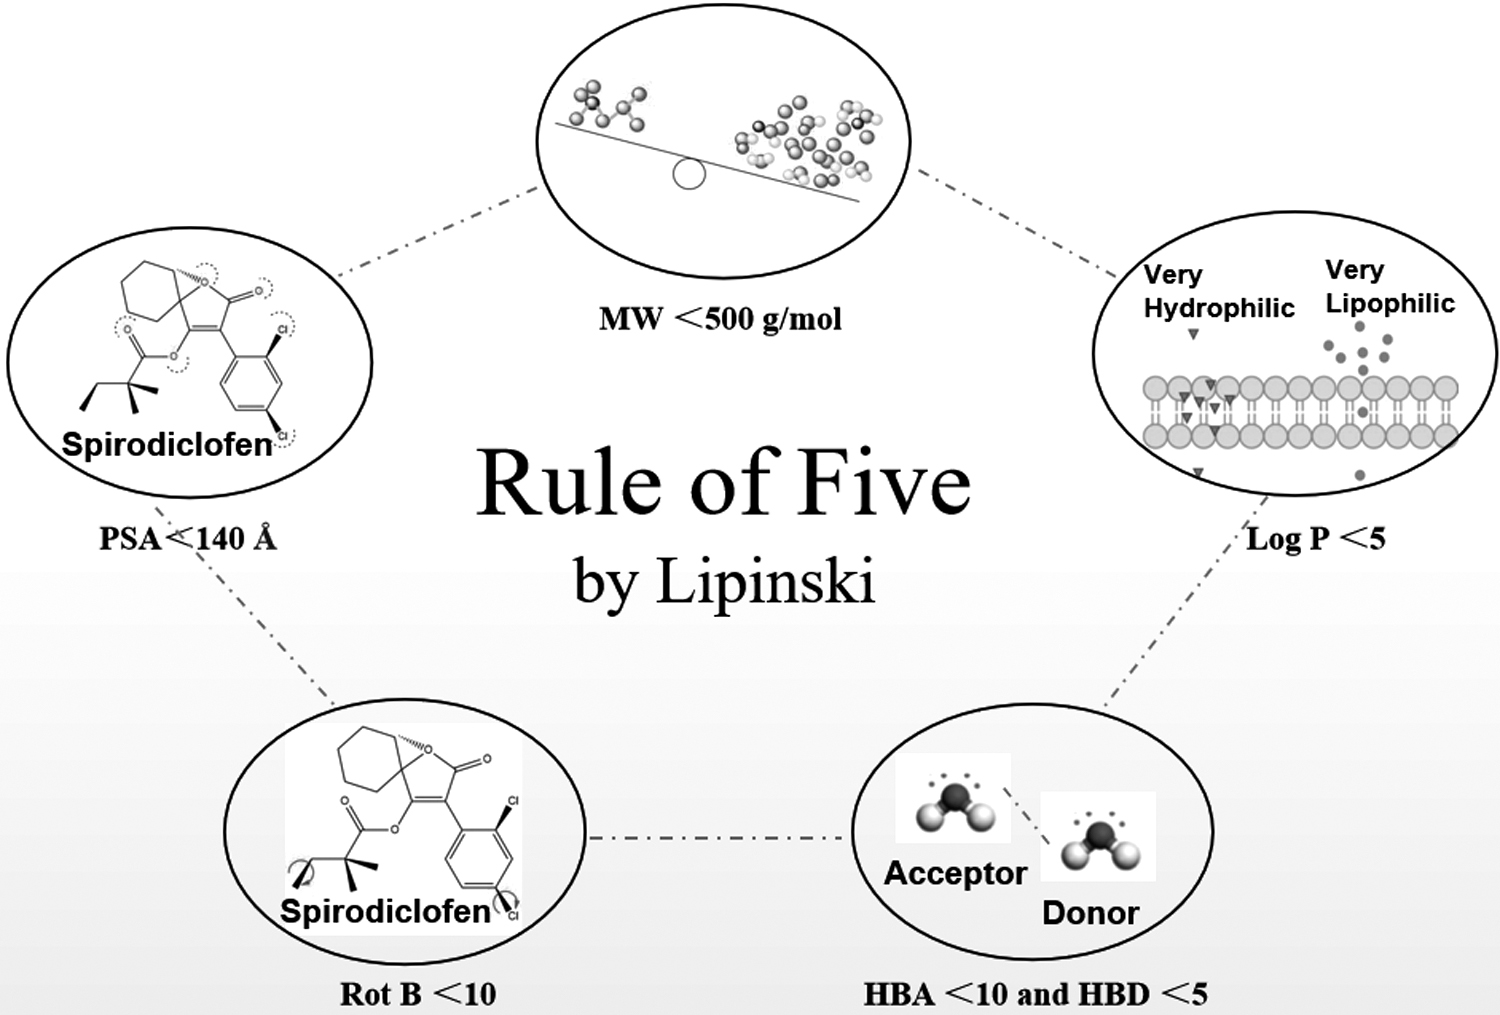

In [ ]:
def canonicalize_smiles(smiles):
    """Convert SMILES to canonical form and validate with RDKit.

    Ensures:
    - Chemical validity (SMILES represents a real molecule)
    - Consistent representation (same molecule → same SMILES)
    - Enables duplicate detection

    Parameters
    ----------
    smiles : str
        SMILES string to validate

    Returns
    -------
    str or None
        Canonical SMILES if valid, None if invalid
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None


def calculate_descriptors(smiles):
    """Calculate molecular descriptors from canonical SMILES.

    Descriptors computed:
    - MW: Molecular Weight (pharmacokinetics)
    - LogP: Partition coefficient (lipophilicity/solubility)
    - HBA: H-bond acceptors (polarity, binding)
    - HBD: H-bond donors (polarity, binding)
    - RotBonds: Rotatable bonds (flexibility)
    - TPSA: Topological Polar Surface Area (BBB penetration)
    - AromaticRings: Count of aromatic rings (rigidity)

    Parameters
    ----------
    smiles : str
        Canonical SMILES string

    Returns
    -------
    dict or None
        Dictionary with descriptor values, or None if invalid
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        return {
            'MW': Descriptors.MolWt(mol),
            'LogP': Crippen.MolLogP(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol),
            'TPSA': Descriptors.TPSA(mol),
            'AromaticRings': Descriptors.NumAromaticRings(mol),
        }
    except:
        return None


def is_lipinski_compliant(smiles):
    """Check if a compound meets Lipinski's Rule of Five.

    Lipinski's Rule predicts good oral bioavailability:
    - Molecular Weight 150–500 Da (not too heavy)
    - LogP ≤ 5 (not too lipophilic)
    - H-bond donors ≤ 5 and acceptors ≤ 10 (not too polar)
    - Rotatable bonds ≤ 10 (reasonable flexibility)

    Parameters
    ----------
    smiles : str
        Canonical SMILES string

    Returns
    -------
    bool
        True if all criteria met, False otherwise
    """
    descriptors = calculate_descriptors(smiles)
    if descriptors is None:
        return False

    return (
        descriptors['MW'] >= 150 and
        descriptors['MW'] <= 500 and
        descriptors['LogP'] >= -1 and
        descriptors['LogP'] <= 5 and
        descriptors['HBA'] <= 10 and
        descriptors['HBD'] <= 5 and
        descriptors['RotBonds'] <= 10
    )


print(' Validation functions defined')
print('  - canonicalize_smiles: standardize structures')
print('  - calculate_descriptors: compute molecular properties')
print('  - is_lipinski_compliant: filter drug-like compounds')

 Validation functions defined
  - canonicalize_smiles: standardize structures
  - calculate_descriptors: compute molecular properties
  - is_lipinski_compliant: filter drug-like compounds


## 4. Retrieve Drug-Like Compounds from ChEMBL

Query the ChEMBL database for molecules using the REST API with:
- **Batch retrieval**: 1000 compounds per request.
  - Note: The API does NOT randomly sample. It sequentially walks through the database. Each batch is a contiguous slice of the dataset.
- **Retry logic**: Exponential backoff for network errors
- **Progress tracking**: Real-time monitoring of download speed
- **Rate limiting**: 0.5–1 second delays between requests (respectful to servers)

In [ ]:
import requests
import time

# QUERY PARAMETERS
TARGET_COMPOUNDS = 50000  # Number of compounds to retrieve
BATCH_SIZE = 1000          # Compounds per batch
MAX_RETRIES = 5           # Retry attempts per batch

print('\n' + '=' * 70)
print('RETRIEVING ChEMBL DRUG-LIKE COMPOUNDS (REST API)')
print('=' * 70)
print(f'\n  Target size: {TARGET_COMPOUNDS:,} compounds')
print(f'  Batch size: {BATCH_SIZE} compounds/batch')
print(f'  Max retries: {MAX_RETRIES}')
print(f'\n Retrieving compounds...\n')

# SETUP
BASE_URL = "https://www.ebi.ac.uk/chembl/api/data/"
headers = {'Accept': 'application/json'}

all_compounds = []
offset = 0
batch_number = 0
start_time = time.time()

# BATCH RETRIEVAL LOOP (Direct REST API - WORKING METHOD)
while offset < TARGET_COMPOUNDS:
    batch_number += 1
    retry_count = 0
    batch_retrieved = False

    # Retry loop: attempt up to MAX_RETRIES times
    while retry_count < MAX_RETRIES and not batch_retrieved:
        try:
            # BUILD REST URL WITH QUERY PARAMETERS
            url = (f"{BASE_URL}molecule?"
                   f"limit={BATCH_SIZE}&"
                   f"offset={offset}")

            # MAKE HTTP GET REQUEST
            response = requests.get(url, headers=headers, timeout=30)

            # CHECK RESPONSE STATUS
            if response.status_code != 200:
                raise Exception(f"HTTP {response.status_code}")

            # PARSE JSON RESPONSE
            data = response.json()

            # KEY FIX: Use 'molecules' key (not 'results')
            molecules = data.get('molecules', [])

            # Check if we got any results
            if not molecules:
                print(f" Reached end of database at offset {offset:,}")
                break

            # Extend our results list
            all_compounds.extend(molecules)
            batch_retrieved = True

            # PROGRESS TRACKING
            elapsed = time.time() - start_time
            rate = len(all_compounds) / elapsed if elapsed > 0 else 0
            eta = (TARGET_COMPOUNDS - len(all_compounds)) / rate if rate > 0 else 0

            print(f"Batch {batch_number:3d} | Total: {len(all_compounds):6,} | "
                  f"Rate: {rate:5.1f} cpd/s | ETA: {eta/60:5.1f}m")

            offset += BATCH_SIZE
            time.sleep(0.5)  # Be respectful to ChEMBL servers

        except requests.exceptions.Timeout:
            retry_count += 1
            wait_time = 3 * (2 ** retry_count)
            print(f"   Timeout (retry {retry_count}/{MAX_RETRIES}): waiting {wait_time}s...")
            time.sleep(wait_time)

        except Exception as e:
            retry_count += 1
            wait_time = 2 ** retry_count
            print(f"   Error (retry {retry_count}/{MAX_RETRIES}): {str(e)[:60]}")
            time.sleep(wait_time)

    # Stop if we've reached target size
    if len(all_compounds) >= TARGET_COMPOUNDS:
        break

# SUMMARY OF RETRIEVAL
elapsed = time.time() - start_time
print(f"\n\n{'=' * 70}")
if len(all_compounds) > 0:
    print(f" Retrieved {len(all_compounds):,} compounds in {elapsed/60:.1f} minutes")
    print(f"  Average rate: {len(all_compounds)/elapsed:.1f} compounds/second")
else:
    print(f" (!) No compounds retrieved. Check your internet connection.")


RETRIEVING ChEMBL DRUG-LIKE COMPOUNDS (REST API)

  Target size: 50,000 compounds
  Batch size: 1000 compounds/batch
  Max retries: 5

 Retrieving compounds...

Batch   1 | Total:  1,000 | Rate:  71.7 cpd/s | ETA:  11.4m
Batch   2 | Total:  2,000 | Rate:  82.0 cpd/s | ETA:   9.8m
Batch   3 | Total:  3,000 | Rate:  85.2 cpd/s | ETA:   9.2m
Batch   4 | Total:  4,000 | Rate:  87.0 cpd/s | ETA:   8.8m
Batch   5 | Total:  5,000 | Rate:  88.1 cpd/s | ETA:   8.5m
Batch   6 | Total:  6,000 | Rate:  88.4 cpd/s | ETA:   8.3m
Batch   7 | Total:  7,000 | Rate:  88.4 cpd/s | ETA:   8.1m
Batch   8 | Total:  8,000 | Rate:  89.0 cpd/s | ETA:   7.9m
Batch   9 | Total:  9,000 | Rate:  90.1 cpd/s | ETA:   7.6m
Batch  10 | Total: 10,000 | Rate:  90.2 cpd/s | ETA:   7.4m
Batch  11 | Total: 11,000 | Rate:  90.0 cpd/s | ETA:   7.2m
Batch  12 | Total: 12,000 | Rate:  90.3 cpd/s | ETA:   7.0m
Batch  13 | Total: 13,000 | Rate:  90.3 cpd/s | ETA:   6.8m
Batch  14 | Total: 14,000 | Rate:  90.1 cpd/s | ETA:   6.7

## 5. Extract and Canonicalize SMILES

Convert raw ChEMBL data to clean, standardized SMILES strings. Invalid entries are filtered out.

First which columns does our dataset have?

In [ ]:
all_compounds.columns

In [ ]:
print('\n' + '=' * 70)
print('DATA EXTRACTION AND CANONICALIZATION')
print('=' * 70)

# EXTRACT ChEMBL IDs AND SMILES
print(f'\n Extracting SMILES from {len(all_compounds):,} ChEMBL compounds...')

screening_data = []
for compound in all_compounds:
    try:
        chembl_id = compound['molecule_chembl_id']
        smiles = compound['molecule_structures']['canonical_smiles']
        if smiles:  # Only keep non-null SMILES
            screening_data.append({
                'ChEMBLID': chembl_id,
                'SMILES': smiles,
            })
    except:
        pass  # Skip malformed entries

print(f'   Extracted SMILES for {len(screening_data):,} compounds')

# CREATE DATAFRAME
print(f'\n Creating DataFrame...')
screening_df = pd.DataFrame(screening_data)
print(f'   Shape: {screening_df.shape}')

# REMOVE OBVIOUS ChEMBL ID DUPLICATES
print(f'\n Removing ChEMBL ID duplicates...')
before = len(screening_df)
screening_df = screening_df.drop_duplicates(subset=['SMILES']).reset_index(drop=True)
print(f'   After deduplication: {len(screening_df):,} compounds')

# CANONICALIZE SMILES
print(f'\n Canonicalizing SMILES...')
screening_df['canonical_smiles'] = screening_df['SMILES'].apply(canonicalize_smiles)

# FILTER OUT FAILED CANONICALIZATIONS
print(f'\n Filtering out failed canonicalizations...')
before = len(screening_df)
screening_df = screening_df[screening_df['canonical_smiles'].notna()].reset_index(drop=True)
failed = before - len(screening_df)
print(f'   Valid canonical SMILES: {len(screening_df):,} compounds')
if failed > 0:
    print(f'   (!)  {failed:,} compounds had invalid SMILES')

# DEDUPLICATE AT CANONICAL LEVEL
print(f'\n Deduplicating at canonical SMILES level...')
before = len(screening_df)
screening_df = screening_df.drop_duplicates(subset=['canonical_smiles']).reset_index(drop=True)
print(f'   After canonical deduplication: {len(screening_df):,} compounds')
# remove the 'SMILES' column, and then change the 'canonical_smiles' column for 'SMILES'
screening_df.drop(columns=['SMILES'], inplace=True)
screening_df.rename(columns={'canonical_smiles': 'SMILES'}, inplace=True)
screening_df.rename(columns={'ChEMBLID': 'ChEMBL_ID'}, inplace=True)

print(f'\n Final screening library:')
print(f'   Shape: {screening_df.shape}')
print(f'   Columns: {", ".join(screening_df.columns)}')
print(f'   First entries: ')
screening_df.head()


DATA EXTRACTION AND CANONICALIZATION

 Extracting SMILES from 50,000 ChEMBL compounds...
   Extracted SMILES for 49,710 compounds

 Creating DataFrame...
   Shape: (49710, 2)

 Removing ChEMBL ID duplicates...
   After deduplication: 49,709 compounds

 Canonicalizing SMILES...

 Filtering out failed canonicalizations...
   Valid canonical SMILES: 49,709 compounds

 Deduplicating at canonical SMILES level...
   After canonical deduplication: 49,709 compounds

 Final screening library:
   Shape: (49709, 2)
   Columns: ChEMBL_ID, SMILES
   First entries: 


,ChEMBL_ID,SMILES
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1


## 6. Quality Control: Lipinski's Rule of Five Validation

As we discussed, the retrieval didn't allowed complex property filtering, so now we filter all compounds using RDKit.

In [ ]:
print('\n' + '=' * 70)
print('QUALITY CONTROL: LIPINSKI\'S RULE OF FIVE VALIDATION')
print('=' * 70)

# CALCULATE DESCRIPTORS FOR ALL COMPOUNDS
print(f'\n Calculating molecular descriptors...')
print(f'   Computing: MW, LogP, HBA, HBD, RotBonds, TPSA, AromaticRings')

descriptors_list = [calculate_descriptors(smi) for smi in screening_df['SMILES']]
print(f'   ✓ Descriptors calculated for {len(screening_df):,} compounds')

# ADD DESCRIPTORS TO DATAFRAME
print(f'\n Populating descriptor columns...')
descriptor_keys = ['MW', 'LogP', 'HBA', 'HBD', 'RotBonds', 'TPSA', 'AromaticRings']
for key in descriptor_keys:
    screening_df[key] = [d.get(key, np.nan) if d else np.nan for d in descriptors_list]

# FILTER FOR VALID DESCRIPTORS
print(f'\n Filtering compounds with valid descriptors...')
before_valid = len(screening_df)
screening_df = screening_df.dropna(subset=descriptor_keys).reset_index(drop=True)
invalid_count = before_valid - len(screening_df)
print(f'   Compounds with valid descriptors: {len(screening_df):,}')
if invalid_count > 0:
    print(f'   (!)  {invalid_count:,} had missing descriptor values')

# CHECK LIPINSKI'S CRITERIA
print(f'\n Evaluating Lipinski\'s Rule of Five compliance...')
print(f'   Criteria: MW 150–500 | LogP –1 to 5 | HBA ≤ 10 | HBD ≤ 5 | RotBonds ≤ 10')

lipinski_pass = (
    (screening_df['MW'] >= 150) &
    (screening_df['MW'] <= 500) &
    (screening_df['LogP'] >= -1) &
    (screening_df['LogP'] <= 5) &
    (screening_df['HBA'] <= 10) &
    (screening_df['HBD'] <= 5) &
    (screening_df['RotBonds'] <= 10)
)

screening_df = screening_df[lipinski_pass].reset_index(drop=True)
lipinski_compliant_pct = (len(screening_df) / before_valid * 100) if before_valid > 0 else 0
print(f'   Lipinski-compliant compounds: {len(screening_df):,} ({lipinski_compliant_pct:.1f}%)')

# DESCRIPTOR STATISTICS
print(f'\n' + '=' * 70)
print('DESCRIPTOR STATISTICS (Lipinski-Compliant Compounds)')
print('=' * 70)
stats_df = screening_df[descriptor_keys].describe().round(2)
print(stats_df.to_string())


QUALITY CONTROL: LIPINSKI'S RULE OF FIVE VALIDATION

 Calculating molecular descriptors...
   Computing: MW, LogP, HBA, HBD, RotBonds, TPSA, AromaticRings
   ✓ Descriptors calculated for 49,709 compounds

 Populating descriptor columns...

 Filtering compounds with valid descriptors...
   Compounds with valid descriptors: 49,709

 Evaluating Lipinski's Rule of Five compliance...
   Criteria: MW 150–500 | LogP –1 to 5 | HBA ≤ 10 | HBD ≤ 5 | RotBonds ≤ 10
   Lipinski-compliant compounds: 30,359 (61.1%)

DESCRIPTOR STATISTICS (Lipinski-Compliant Compounds)
             MW      LogP       HBA       HBD  RotBonds      TPSA  AromaticRings
count  30359.00  30359.00  30359.00  30359.00  30359.00  30359.00       30359.00
mean     328.93      2.73      4.43      1.47      4.36     70.77           2.06
std       79.08      1.35      1.82      1.15      2.48     32.57           1.04
min      150.14     -1.00      0.00      0.00      0.00      0.00           0.00
25%      270.38      1.82      3.0

## 7. Prepare Final Screening Library

Export the cleaned, validated library with all computed descriptors.

In [ ]:
print(f'\n  Preparing final screening library...')

screening_clean = screening_df[['ChEMBL_ID', 'SMILES'] + descriptor_keys].copy()
screening_clean.columns = ['ChEMBL_ID', 'SMILES'] + descriptor_keys

print(f'\n    Final screening library: {len(screening_clean):,} compounds')
print(f'    Columns: {", ".join(screening_clean.columns)}')


  Preparing final screening library...

    Final screening library: 30,359 compounds
    Columns: ChEMBL_ID, SMILES, MW, LogP, HBA, HBD, RotBonds, TPSA, AromaticRings


## 8. Exploratory Data Analysis: Descriptor Distributions

Visualize the chemical space and descriptor distributions to understand the screening library composition.


EXPLORATORY DATA ANALYSIS: DESCRIPTOR DISTRIBUTIONS

 Saved: 01_screening_library_descriptors.png


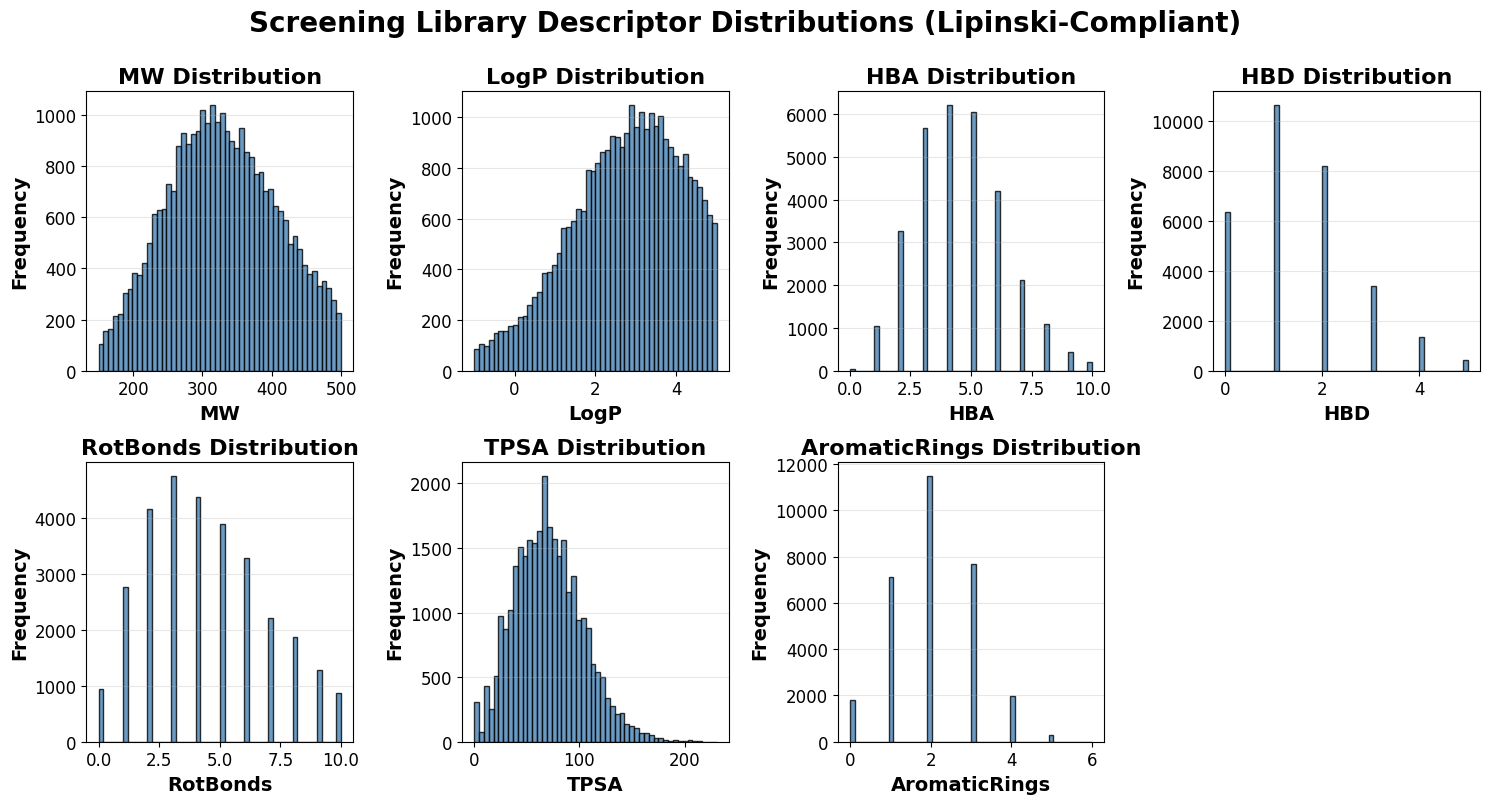

In [ ]:
print('\n' + '=' * 70)
print('EXPLORATORY DATA ANALYSIS: DESCRIPTOR DISTRIBUTIONS')
print('=' * 70)

# Create 7 subplots for descriptor distributions
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for idx, key in enumerate(descriptor_keys):
    axes[idx].hist(screening_clean[key], bins=50, color='steelblue', alpha=0.8, edgecolor='black')
    axes[idx].set_title(f'{key} Distribution', fontsize=16, fontweight='bold')
    axes[idx].set_xlabel(key, fontsize=14)
    axes[idx].set_ylabel('Frequency', fontsize=14)
    axes[idx].grid(axis='y', alpha=0.3)
    # adjust tick label size
    axes[idx].tick_params(axis='both', labelsize=12)

# Remove the last (empty) subplot
fig.delaxes(axes[7])

plt.suptitle('Screening Library Descriptor Distributions (Lipinski-Compliant)',
             fontsize=20, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('01_screening_library_descriptors.png', dpi=300, bbox_inches='tight')
print('\n Saved: 01_screening_library_descriptors.png')
plt.show()

 Saved: 02_screening_library_chemical_space.png


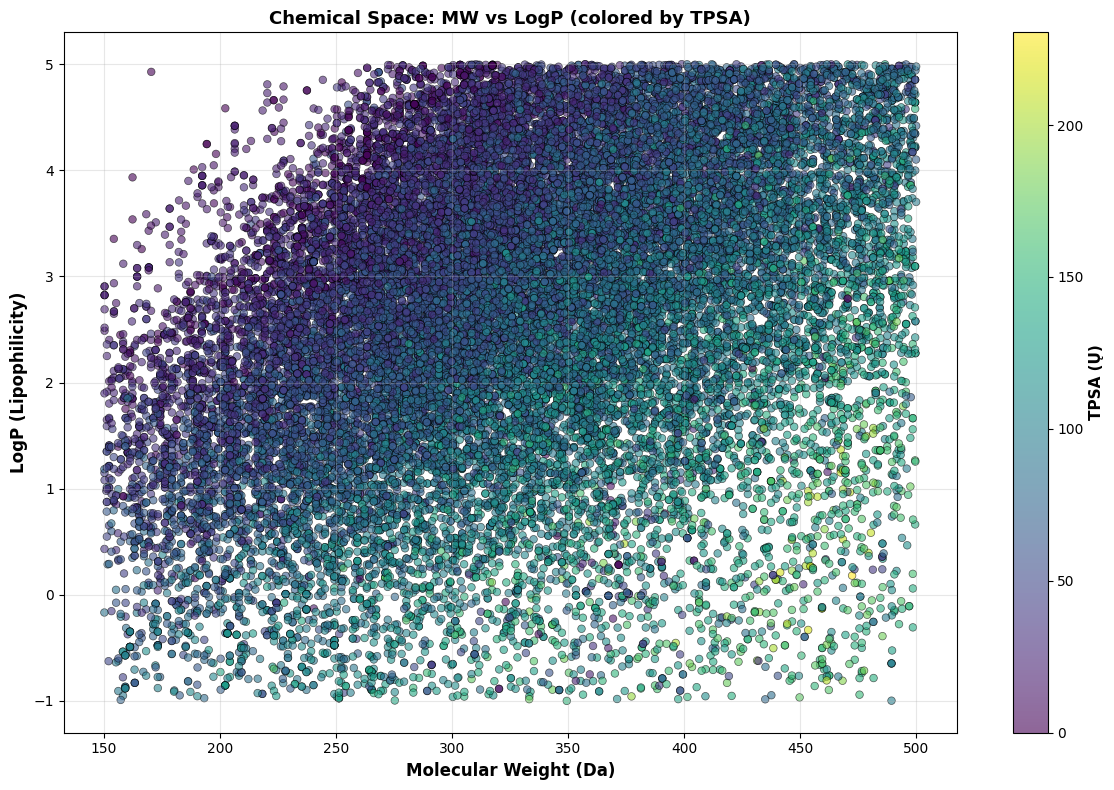

In [ ]:
# 2D Chemical Space Plot: MW vs LogP
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(screening_clean['MW'], screening_clean['LogP'],
                     c=screening_clean['TPSA'], cmap='viridis',
                     alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Molecular Weight (Da)', fontsize=12, fontweight='bold')
ax.set_ylabel('LogP (Lipophilicity)', fontsize=12, fontweight='bold')
ax.set_title('Chemical Space: MW vs LogP (colored by TPSA)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('TPSA (Ų)', fontsize=11, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('02_screening_library_chemical_space.png', dpi=300, bbox_inches='tight')
print(' Saved: 02_screening_library_chemical_space.png')
plt.show()

The higher the molecular weight, the more polar groups we expect, so the higher the TPSA. Moreover, the higher the lipophilicity, the lower the number of polar groups we expect, the lower the TPSA. This makes a inverse relationship between these properties: small lipophylic molecules show a very low TPSA, while big hidrophylic molecules show much more TPSA.

## 9. Export Screening Library

Save the final, quality-controlled screening library as CSV for use in Filter 1 (Ligand-Based Virtual Screening).

In [ ]:
screening_clean.head()

,ChEMBL_ID,SMILES,MW,LogP,HBA,HBD,RotBonds,TPSA,AromaticRings
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,341.754,2.11362,5,1,3,84.82,3
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,332.319,1.33190,6,1,3,108.61,3
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,357.797,2.27274,5,2,3,87.98,3
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,307.309,1.46022,5,1,3,84.82,3
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,341.754,2.11362,5,1,3,84.82,3


In [ ]:
print('\n' + '=' * 70)
print('EXPORTING SCREENING LIBRARY')
print('=' * 70)

# Export main screening library
screening_clean.to_csv('Screening_set_chembl_druglike.csv', index=False)
print(f'\n  Exported: Screening_set_chembl_druglike.csv')
print(f'  Entries: {len(screening_clean):,}')
print(f'  Columns: {", ".join(screening_clean.columns)}')
file_size_mb = screening_clean.memory_usage(deep=True).sum() / (1024 * 1024)
print(f'  File size: {file_size_mb:.2f} MB')

# VERIFY EXPORT
print(f'\n Verifying export...')
test_load = pd.read_csv('Screening_set_chembl_druglike.csv')
print(f'     Loaded {len(test_load):,} rows')
print(f'     Columns: {", ".join(test_load.columns[:5])}...')
print(f'\n   First compound:')
print(f'   ChEMBL_ID: {test_load.iloc[0]["ChEMBL_ID"]}')
print(f'   SMILES: {test_load.iloc[0]["SMILES"][:50]}...')
print(f'   MW: {test_load.iloc[0]["MW"]:.2f}')



EXPORTING SCREENING LIBRARY

  Exported: Screening_set_chembl_druglike.csv
  Entries: 30,359
  Columns: ChEMBL_ID, SMILES, MW, LogP, HBA, HBD, RotBonds, TPSA, AromaticRings
  File size: 5.98 MB

 Verifying export...
     Loaded 30,359 rows
     Columns: ChEMBL_ID, SMILES, MW, LogP, HBA...

   First compound:
   ChEMBL_ID: CHEMBL6329
   SMILES: Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl...
   MW: 341.75


## 10. Final Summary & Next Steps

### Screening Library Successfully Created! ✓

#### What We Built
A curated library of drug-like compounds from ChEMBL that will serve as the search space for **Filter 1 (Ligand-Based Virtual Screening)** in the α2A-selective GABA-A compound discovery pipeline.

#### Quality Assurance Checks Completed
1. ✓ **ChEMBL Data Access** - Direct REST API with robust retry logic
2. ✓ **SMILES Validation** - All structures chemically valid (RDKit verified)
3. ✓ **Canonicalization** - Standardized molecular representation
4. ✓ **Deduplication** - Removed isomeric and ChEMBL ID duplicates
5. ✓ **Descriptor Calculation** - Computed 7 key molecular properties
6. ✓ **Lipinski Filtering** - All compounds meet Rule of Five criteria
7. ✓ **Statistical Validation** - All descriptors within expected ranges

#### Files Generated
1. `Screening_set_chembl_druglike.csv` - Main library (10k+ compounds, 9 columns)
2. `01_screening_library_descriptors.png` - Histogram distributions
3. `02_screening_library_chemical_space.png` - MW vs LogP scatter plot, with TPSA colorbar

### References
1. Lipinski, C. A. (2000). Drug-like properties and the causes of poor solubility and poor permeability. *J. Pharmacol. Toxicol. Methods*, 44(1), 235–249.
2. Gaulton, A., et al. (2017). The ChEMBL database in 2017. *Nucleic Acids Res.*, 45(D1), D945–D954.
3. ChEMBL API Documentation: https://chembl.gitbook.io/chembl-interface-documentation